# Data block API foundations

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_07a import *

## Image ItemList

Let's grab the imagenette dataset and build the data blocks we need along the way.

### Get images

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/ubuntu/.fastai/data/imagenette-160')

To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [ ]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [ ]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/models'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val')]

In [ ]:
(path/'val').ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03425413')]

Let's have a look inside a class folder (the first class is tench):

In [ ]:
path_tench = path/'val'/'n01440764'

In [ ]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00007197.JPEG')

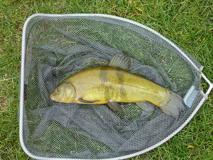

In [ ]:
img = PIL.Image.open(img_fn)
img

Just in case there are other files in the directory (models, texts...) we want to keep only the images:

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
' '.join(image_extensions)

'.tiff .jpe .svg .ras .tif .bmp .jpg .rgb .pbm .xbm .pnm .ppm .ico .gif .xwd .xpm .ief .png .pgm .jpeg'

In [ ]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [ ]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

In [ ]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00007197.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00029930.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00030740.JPEG')]

In [ ]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for p,d,f in os.walk(path): # returns (dirpath, dirnames, filenames)
            if include is not None: d[:] = [o for o in d if o in include]
            else:                   d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [ ]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017995.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009379.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00003014.JPEG')]

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [ ]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009593.JPEG')]

In [ ]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [ ]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

75.9 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the `ListContainer` class from 08 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for list of indices) to create training and validation set from a single stream when we split the data.

In [ ]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    def new(self, items): return self.__class__(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageItemList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageItemList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

In [ ]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [ ]:
il = ImageItemList.from_files(path, tfms=make_rgb)

In [ ]:
il

ImageItemList (13394 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00034544.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009593.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00029149.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00037770.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00009370.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00031268.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00047147.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00031035.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00020698

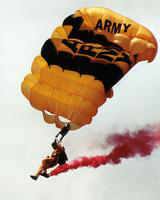

In [ ]:
img = il[0]; img

In [ ]:
il[:1]

[<PIL.Image.Image image mode=RGB size=160x200 at 0x7F70D82826D8>]

### Split validation set

Here, we need to split the files between those in train and those in val.

In [ ]:
fn = il.items[0]; fn

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00016387.JPEG')

In [ ]:
fn.parent.parent.name

'val'

In [ ]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(ds, f):
    items = ds.items
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    train = [o for o,m in zip(items,mask) if m==False]
    valid = [o for o,m in zip(items,mask) if m==True ]
    return train,valid

In [ ]:
splitter = partial(grandparent_splitter, valid_name='val')

In [ ]:
train,valid = split_by_func(il, splitter)

In [ ]:
len(train),len(valid)

(12894, 500)

In [ ]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    @property
    def path(self): return self.train.path
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [ ]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageItemList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_6402.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_4446.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_22655.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_29390.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_17004.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_8837.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_19451.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_12883.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_13476.JPEG')...]
Path: /home/ubuntu/.fastai/data/ima

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A `Processor` is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be processing texts to tokenize, then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the Processor and applied on the validation set.

In our case, we want to convert label strings in to numbers in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

In [ ]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

First, let's define the processor. We also defined a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1. The corresponding obj will be the name of the class.

In [ ]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    def proc1(self, item):  return self.otoi[item]
    def deproc1(self, idx): return self.vocab[idx]
    
    def process(self, items):
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]

class ProcessedItemList(ListContainer):
    def __init__(self, inputs, processor):
        self.processor = processor
        items = processor.process(inputs)
        super().__init__(items)
        
    def obj(self, idx):
        res = self[idx]
        if isinstance(res,(tuple,list,Generator)): return self.processor.deprocess(res)
        return self.processor.deproc1(idx)

Here we label according to the folders of the images.

In [ ]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f): return [f(o) for o in ds.items]

class LabeledData():
    def __init__(self, x, y): self.x,self.y = x,y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    @classmethod
    def label_by_func(cls, sd, f, proc=None):
        labels = _label_by_func(sd, f)
        proc_labels = ProcessedItemList(labels, proc)
        return cls(sd, proc_labels)

def label_by_func(sd, f):
    proc = CategoryProcessor()
    train = LabeledData.label_by_func(sd.train, f, proc)
    valid = LabeledData.label_by_func(sd.valid, f, proc)
    return SplitData(train,valid)

In [ ]:
ll = label_by_func(sd, parent_labeler)

In [ ]:
assert ll.train.y.processor is ll.valid.y.processor

In [ ]:
ll.train.y.items[0],ll.train.y.obj(0),ll.train.y.obj(slice(2))

(0, 'n03888257', ['n03888257', 'n03888257'])

In [ ]:
ll

SplitData
Train: LabeledData
x: ImageItemList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_9403.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_6402.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_4446.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_22655.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_29390.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_17004.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_8837.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_19451.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_12883.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n03888257/n03888257_13476.JPEG')...]
Path: /home/ubuntu/.

### Transform to tensor

To be able to put all our images in a batch, we need them to have all the same size. That's what the first transform does, using PIL. Then we convert the image to a by tensor before converting it to float and dividing by 255.

In [ ]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler)

A convenience function to show an image from the corresponding tensor.

In [ ]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [ ]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

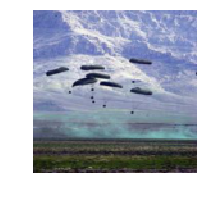

In [ ]:
show_image(x)

## Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
x,y = next(iter(train_dl))

In [ ]:
x.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n03000684'

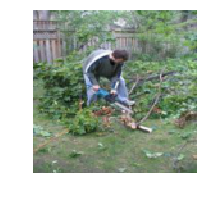

In [ ]:
show_image(x[0])
ll.train.y.processor.vocab[y[0]]

In [ ]:
y

tensor([9, 0, 6, 4, 7, 4, 2, 4, 2, 5, 0, 5, 8, 4, 7, 0, 8, 7, 9, 4, 0, 3, 5, 0,
        5, 0, 1, 4, 6, 8, 4, 7, 7, 6, 3, 2, 8, 8, 9, 2, 2, 5, 8, 0, 4, 0, 4, 8,
        6, 3, 0, 0, 1, 9, 4, 4, 6, 8, 0, 6, 0, 2, 0, 4])

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

In [ ]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

### Model

We will normalize with the statistics from a batch.

In [ ]:
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda()
m,s

(tensor([0.4779, 0.4773, 0.4711], device='cuda:0'),
 tensor([0.2664, 0.2643, 0.2887], device='cuda:0'))

In [ ]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [ ]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), plus `bn_final`.

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
#export
import math
def next_pow_2(x): return 2**math.ceil(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = next_pow_2(l1*2)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=1),
               f(l2*2, l2*4, stride=1)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out),
               nn.BatchNorm1d(data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.7803628080405616, tensor(0.3925, device='cuda:0')]
valid: [1.669792236328125, tensor(0.4540, device='cuda:0')]
train: [1.299257709496665, tensor(0.5666, device='cuda:0')]
valid: [1.224145751953125, tensor(0.6180, device='cuda:0')]
CPU times: user 28.8 s, sys: 13.3 s, total: 42.1 s
Wall time: 44.2 s


## Export

In [ ]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
